In [4]:
import pandas as pd
import numpy as np

# -----------------------------
# 1. Load datasets
# -----------------------------
bio = pd.read_csv("api_data_aadhar_biometric/api_data_aadhar_biometric_full.csv")
demo = pd.read_csv("api_data_aadhar_demographic/api_data_aadhar_demographic/api_data_aadhar_demographic_full.csv")
enrol = pd.read_csv("api_data_aadhar_enrolment/api_data_aadhar_enrolment/api_data_aadhar_enrolment_full.csv")

# -----------------------------
# 2. Merge datasets
# -----------------------------
df = bio.merge(
    demo,
    on=["date", "state", "district", "pincode"],
    how="inner"
).merge(
    enrol,
    on=["date", "state", "district", "pincode"],
    how="inner"
)

# -----------------------------
# 3. AGE GROUP: 5–17
# -----------------------------
df["bio_coverage_5_17"] = df["bio_age_5_17"] / df["age_5_17"]

df["fallback_ratio_5_17"] = (
    df["demo_age_5_17"] /
    (df["bio_age_5_17"] + df["demo_age_5_17"] + 1e-6)
)

df["stress_index_5_17"] = df["demo_age_5_17"] / df["age_5_17"]

# -----------------------------
# 4. AGE GROUP: 18+
# -----------------------------
df["bio_coverage_18_plus"] = df["bio_age_17_"] / df["age_18_greater"]

df["fallback_ratio_18_plus"] = (
    df["demo_age_17_"] /
    (df["bio_age_17_"] + df["demo_age_17_"] + 1e-6)
)

df["stress_index_18_plus"] = df["demo_age_17_"] / df["age_18_greater"]

# -----------------------------
# 5. Risk Score (Weighted)
# -----------------------------
df["risk_score_18_plus"] = (
    0.4 * (1 - df["bio_coverage_18_plus"]) +
    0.35 * df["fallback_ratio_18_plus"] +
    0.25 * df["stress_index_18_plus"]
)

# -----------------------------
# 6. Risk Classification
# -----------------------------
def classify_risk(score):
    if score < 0.3:
        return "Low"
    elif score < 0.6:
        return "Medium"
    else:
        return "High"

df["risk_level_18_plus"] = df["risk_score_18_plus"].apply(classify_risk)

# -----------------------------
# 7. Final Output Columns
# -----------------------------
final_cols = [
    "date", "state", "district", "pincode",
    "bio_coverage_18_plus",
    "fallback_ratio_18_plus",
    "stress_index_18_plus",
    "risk_score_18_plus",
    "risk_level_18_plus"
]

final_df = df[final_cols]

print(final_df.head(100))


          date           state   district  pincode  bio_coverage_18_plus  \
0   01-04-2025       Rajasthan      Churu   331403             61.250000   
1   01-04-2025       Rajasthan      Churu   331403             61.250000   
2   01-04-2025       Karnataka  Bengaluru   560032             18.840000   
3   01-04-2025       Karnataka  Bengaluru   560032             18.840000   
4   01-04-2025         Gujarat   Mahesana   384001             23.080000   
..         ...             ...        ...      ...                   ...   
95  01-04-2025  Madhya Pradesh     Morena   476001             48.320000   
96  01-04-2025   Uttar Pradesh     Shamli   247776             79.666667   
97  01-04-2025   Uttar Pradesh     Shamli   247776             79.666667   
98  01-04-2025  Madhya Pradesh    Barwani   451551            423.100000   
99  01-04-2025  Madhya Pradesh    Barwani   451551            423.100000   

    fallback_ratio_18_plus  stress_index_18_plus  risk_score_18_plus  \
0              

In [7]:
import pandas as pd
import numpy as np

# ==============================
# 1. LOAD DATA
# ==============================
bio = pd.read_csv("api_data_aadhar_biometric/api_data_aadhar_biometric_full.csv")
demo = pd.read_csv("api_data_aadhar_demographic/api_data_aadhar_demographic/api_data_aadhar_demographic_full.csv")
enrol = pd.read_csv("api_data_aadhar_enrolment/api_data_aadhar_enrolment/api_data_aadhar_enrolment_full.csv")

# ==============================
# 2. MERGE DATASETS
# ==============================
df = (
    bio.merge(demo, on=["date", "state", "district", "pincode"], how="inner")
       .merge(enrol, on=["date", "state", "district", "pincode"], how="inner")
)

# ==============================
# 3. FIX DUPLICATES (TRANSACTION DATA → SUM)
# ==============================
df = df.groupby(
    ["date", "state", "district", "pincode"],
    as_index=False
).sum()

# ==============================
# 4. CORE METRICS (AGE 18+)
# ==============================
eps = 1e-6

# Total authentication attempts
df["total_auth_18_plus"] = df["bio_age_17_"] + df["demo_age_17_"]

# Biometric share (how dominant biometrics are)
df["bio_share_18_plus"] = df["bio_age_17_"] / (df["total_auth_18_plus"] + eps)

# Fallback dependency (primary failure proxy)
df["fallback_ratio_18_plus"] = df["demo_age_17_"] / (df["total_auth_18_plus"] + eps)

# Authentication intensity (retries / friction indicator)
df["auth_intensity_18_plus"] = df["total_auth_18_plus"] / (df["age_18_greater"] + eps)

# ==============================
# 5. NORMALIZE INTENSITY
# ==============================
df["norm_auth_intensity"] = (
    df["auth_intensity_18_plus"] /
    df["auth_intensity_18_plus"].max()
)

# ==============================
# 6. FINAL RISK SCORE (0–1)
# ==============================
df["risk_score_18_plus"] = (
    0.5 * df["fallback_ratio_18_plus"] +
    0.3 * (1 - df["bio_share_18_plus"]) +
    0.2 * df["norm_auth_intensity"]
)

# ==============================
# 7. RISK CLASSIFICATION
# ==============================
def classify_risk(score):
    if score < 0.3:
        return "Low"
    elif score < 0.6:
        return "Medium"
    else:
        return "High"

df["risk_level_18_plus"] = df["risk_score_18_plus"].apply(classify_risk)

# ==============================
# 8. FINAL OUTPUT
# ==============================
final_df = df[
    [
        "date", "state", "district", "pincode",
        "bio_share_18_plus",
        "fallback_ratio_18_plus",
        "auth_intensity_18_plus",
        "risk_score_18_plus",
        "risk_level_18_plus"
    ]
]

print(final_df.head(1000))



           date           state                     district  pincode  \
0    01-04-2025           Assam                   Bongaigaon   783380   
1    01-04-2025           Assam                   Bongaigaon   783384   
2    01-04-2025           Bihar                    Bhagalpur   812005   
3    01-04-2025      Chandigarh                   Chandigarh   160036   
4    01-04-2025    Chhattisgarh                         Durg   491001   
..          ...             ...                          ...      ...   
995  01-09-2025  Andhra Pradesh  Sri Potti Sriramulu Nellore   524142   
996  01-09-2025  Andhra Pradesh  Sri Potti Sriramulu Nellore   524201   
997  01-09-2025  Andhra Pradesh  Sri Potti Sriramulu Nellore   524341   
998  01-09-2025  Andhra Pradesh               Sri Sathya Sai   515159   
999  01-09-2025  Andhra Pradesh               Sri Sathya Sai   515501   

     bio_share_18_plus  fallback_ratio_18_plus  auth_intensity_18_plus  \
0             0.142069                0.857931   

In [8]:
final_df.to_csv("uidai_final_risk_dataset.csv", index=False)



## 1️⃣ Risk Level Distribution (Sanity Check)
✅ Why this matters

Shows that:

Data is not biased

You have Low / Medium / High regions (realistic)


“Risk is naturally distributed, not artificially skewed — indicating a stable scoring method.”

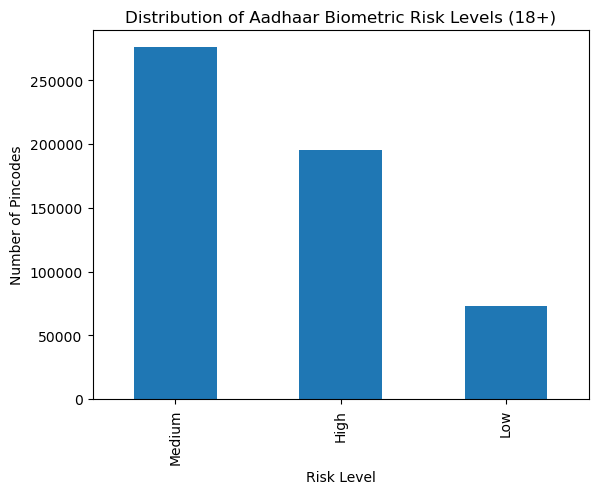

In [10]:
import matplotlib.pyplot as plt

final_df["risk_level_18_plus"].value_counts().plot(kind="bar")
plt.title("Distribution of Aadhaar Biometric Risk Levels (18+)")
plt.xlabel("Risk Level")
plt.ylabel("Number of Pincodes")
plt.show()


## 2️⃣ Fallback Ratio vs Risk Score (MOST IMPORTANT)
✅ Why this matters

This proves your logic:

Higher fallback → higher risk
If this plot trends upward → your model is correct.

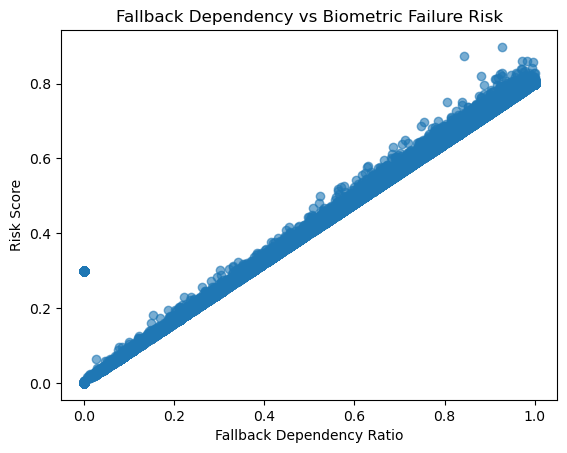

In [11]:
plt.scatter(
    final_df["fallback_ratio_18_plus"],
    final_df["risk_score_18_plus"],
    alpha=0.6
)
plt.xlabel("Fallback Dependency Ratio")
plt.ylabel("Risk Score")
plt.title("Fallback Dependency vs Biometric Failure Risk")
plt.show()
